In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [3]:
import optax

In [24]:
from tqdm import tqdm

In [4]:
from QCBM import QCBM, KLDivergence, MMD

## Mixture of Gaussian

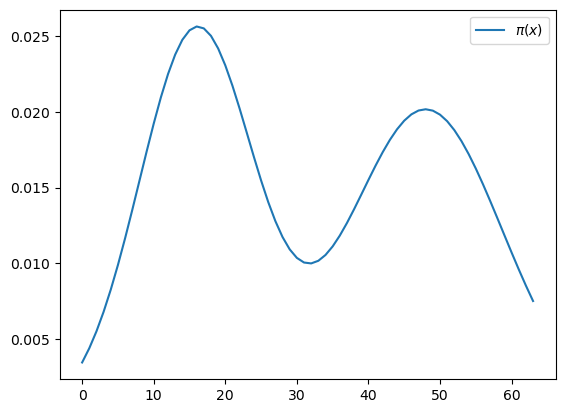

In [5]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(1 / 4) * x_max, (3 / 4) * x_max]
sigmas = [x_max / 8, x_max/6]
data = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

In [22]:
def QCBM_n_qubits(n_layers = 4, n_qubits = 5):
    tol = 1e-9
    x_max = 2**n_qubits
    x_input = np.arange(x_max)
    mus = [(1 / 4) * x_max, (3 / 4) * x_max]
    sigmas = [x_max / 8, x_max/6]
    data = mixture_gaussian_pdf(x_input, mus, sigmas)

    dev = qml.device("default.qubit", wires=n_qubits)

    wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
    weights = np.random.random(size=wshape)

    @qml.qnode(dev)
    def circuit(weights):
        qml.StronglyEntanglingLayers(
            weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
        )
        return qml.probs()


    jit_circuit = jax.jit(circuit)

    bandwidth = jnp.array([0.25, 60])
    space = jnp.arange(2**n_qubits)

    mmd = MMD(bandwidth, space)
    qcbm = QCBM(jit_circuit, mmd, data)

    opt = optax.adam(learning_rate=0.1)
    opt_state = opt.init(weights)

    history = []
    divs = []
    n_iterations = 1000

    for i in range(n_iterations):
        (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
        updates, opt_state = opt.update(grads, opt_state)
        weights = optax.apply_updates(weights, updates)
        kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
        # weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

        # if i % 10 == 0:
        #     print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

        if kl_div < tol:
            break

        history.append(loss_val)
        divs.append(kl_div)

    qcbm_probs = qcbm.circ(weights)

    plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
    plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

    plt.xlabel("Samples")
    plt.ylabel("Prob. Distribution")

    plt.legend()
    plt.show()

    # save lowest kl-divergence

    return history, divs

  0%|          | 0/4 [00:00<?, ?it/s]

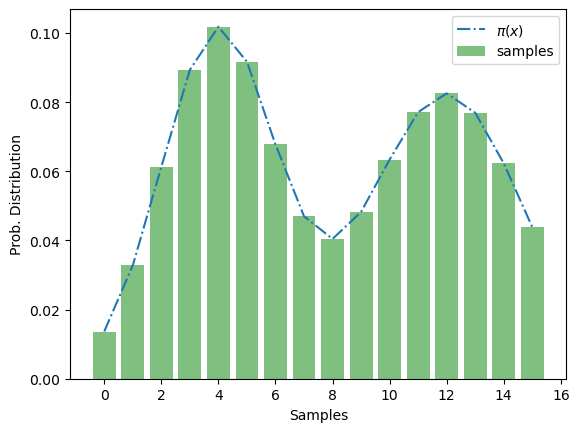

 25%|██▌       | 1/4 [00:02<00:08,  2.69s/it]

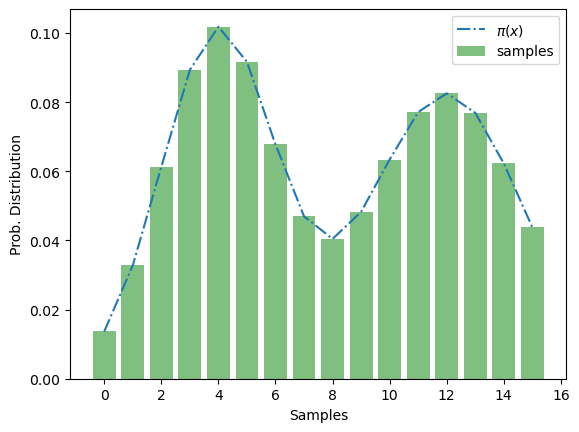

 50%|█████     | 2/4 [00:07<00:07,  3.96s/it]

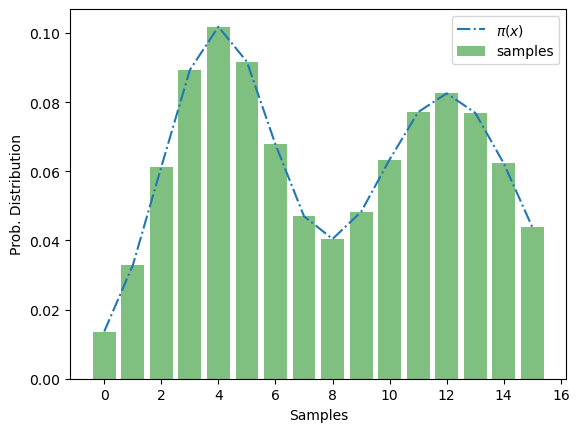

 75%|███████▌  | 3/4 [00:40<00:17, 17.40s/it]

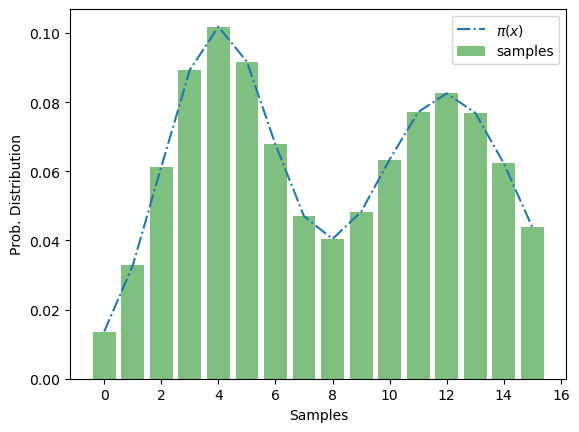

100%|██████████| 4/4 [01:24<00:00, 21.16s/it]


In [26]:
n_layers = [5,10,20,50]
# n_qubits = [4,6,8,10]
# n_layers = [20]
n_qubits = [4]
for layer in tqdm(n_layers):
    for qubits in n_qubits:
        QCBM_n_qubits(n_layers = layer, n_qubits = qubits)